In [62]:
# imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import der Basisdaten

### HIER MÜSSEN WIR NOCH EINMAL FESTHALTEN WOHER UNSERE DATEN KOMMEN UND DAS SAUBER AUFLISTEN

### PV-Daten: Renewables.Ninja
Basierend auf Europäischem Datenset:CM-SAF SARAH (Europe) hohe Genauigkeit, da Angabe aus (lon/lat) -> VLH = 1072

### Temperaturdaten: DWD open database
Basierend auf historischen Daten für das Jahr 2022 der Wetterstation am Flughafen Köln/Bonn (ca. 12km Luftlinie)
-> Kälteanomalie im Dezember: kurzzeitig Temperaturen bis -10-Grad

In [63]:
# data imports
df_data = pd.read_csv("data/Modellierung_SoSe23.csv", sep=";", decimal=",", usecols=[0,1,4])

# load pv_data
pv_data = pd.read_csv("data/ninja_pv_50.8263_6.9721.csv", decimal=".", header=3)

# load and prepare temp data
temp_data = pd.read_csv("data/DWD_wetterdaten_KoelnBonn_Flughafen.txt", sep=";", decimal=".", usecols=[1,3])
temp_data = temp_data[(temp_data['MESS_DATUM'] >= 2022010100) & (temp_data['MESS_DATUM'] < 2023010101)]

# fill dataframe
df_data['pv'] = pv_data['electricity'].to_numpy()
df_data['temp'] = temp_data['TT_TU'].to_numpy()

df_data

,Zeit,electric_load,heat_load,pv,temp
0,01.01. 00:00,0.016247,0.22,0.0,12.6
1,01.01. 01:00,0.016162,0.13,0.0,13.0
2,01.01. 02:00,0.016005,0.07,0.0,12.6
3,01.01. 03:00,0.166450,0.03,0.0,12.2
4,01.01. 04:00,0.016200,0.07,0.0,12.8
...,...,...,...,...,...
8755,31.12. 19:00,1.107500,1.69,0.0,15.1
8756,31.12. 20:00,0.261240,1.73,0.0,15.9
8757,31.12. 21:00,0.289830,1.33,0.0,15.9
8758,31.12. 22:00,0.340810,0.81,0.0,15.6


In [64]:
# calculation and data preparation for heat_pump(wp)

# scraped data
wp_data = {
    "temp" : [-22, -15, -7, 2, 7, 10, 12, 20, 25, 30, 35],
    "heating_power" : [0, 25.50, 35.20, 43.00, 56.40, 60.30, 62.90, 67.30, 70.40, 73.60, 76.70],
    "el_power" : [0, 14.58, 15.54, 16.70, 18.54, 18.87, 18.87, 19.05, 19.13, 19.36, 19.46],
    "cop" : [0, 1.7, 2.3, 2.6, 3.0, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]
}

# assumptions
wp_el_p_nom = 12.5  # kW

# calculate COP
df_data["wp_COP_interp"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["cop"]),3)
df_data["wp_power_consumption"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["el_power"]),2)
df_data['wp_power_cons_norm'] = df_data["wp_power_consumption"] / wp_el_p_nom

df_data

,Zeit,electric_load,heat_load,pv,temp,wp_COP_interp,wp_power_consumption,wp_power_cons_norm
0,01.01. 00:00,0.016247,0.22,0.0,12.6,3.315,18.88,1.5104
1,01.01. 01:00,0.016162,0.13,0.0,13.0,3.325,18.89,1.5112
2,01.01. 02:00,0.016005,0.07,0.0,12.6,3.315,18.88,1.5104
3,01.01. 03:00,0.166450,0.03,0.0,12.2,3.305,18.87,1.5096
4,01.01. 04:00,0.016200,0.07,0.0,12.8,3.320,18.89,1.5112
...,...,...,...,...,...,...,...,...
8755,31.12. 19:00,1.107500,1.69,0.0,15.1,3.378,18.94,1.5152
8756,31.12. 20:00,0.261240,1.73,0.0,15.9,3.398,18.96,1.5168
8757,31.12. 21:00,0.289830,1.33,0.0,15.9,3.398,18.96,1.5168
8758,31.12. 22:00,0.340810,0.81,0.0,15.6,3.390,18.95,1.5160


# Parameter- und Variablendefinition

### Komponenparameter
Für eine leichtere Lesbarkeit und einfachere Zuordnung aller festgelegten Basisparameter, werden Basisdaten in Dictionarys mit eindeutigen Keys definiert

### Basisvariablen 
Generelle Basisvariablen wie z.B. der Strompreis oder die Gebäudedefinition werden in einfachen globalen Variablen gespeichert

In [81]:
# basicvariables
# cost related variables
electricity_rate = 0.4 # €/kWh
infeed_rate = -0.08    # €/kWh

# building related variables
living_space = 157 #m²

# grid parameters


# data calculations 
# -> here <-------------------!


# component parameters
# PV-plant
pv_params = {
    'p_nom': 200,    # kWp
    'p_max_pu': df_data['pv'],
    'capital_cost': (1300*10)/20,
    'marginal_cost': 0,
    'lifespan' : 20    
}

# FuelCell -> fc
fc_params = {
    'p_nom': 1.5, #kW_el Brennstoffzellenleistung picea
    'el_efficiency': 0.8,
    'th_efficiency': 0.2,
    'capital_cost': 800,
    'marginal_cost': 0
}

# Electrolyser -> ely
ely_params = {
    'p_nom': 2.3, #kW_el Wasserstofferzeugungsleistung picea
    'el_efficiency': 0.625,
    'th_efficiency': 0.2,
    'capital_cost': 900,
    'marginal_cost': 0
}

# heatpump -> wp
wp_params = {
    'p_nom': 2.5,
    'efficiency': df_data['wp_COP_interp'],
    'capital_cost': (25000 / 7.5) / 25,
    'marginal_cost': 0
}

# battery storage
battery_params = { # battery integrated in picea system
    'e_nom': 20, #kWh picea system
    #'e_min_pu': 0.2,
    #'e_max_pu': 1.0,
    'capital_cost': 892/12.5,
    'marginal_cost': 0,
    'standing_loss': 0.02,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
}

# heat storage
heat_storage_params = {
    'e_nom': 300, #kWh
    'e_min_pu': 0.6,
    'e_max_pu': 1.0,
    'volume': 300, #Litre
    'capital_cost': 53.32/20,
    'marginal_cost': 0,
    'standing_loss': 0.08,
    'charge_efficiency': 0.95,
    'discharge_efficiency': 0.95,
}

# H2 gas storage
h2_storage_params = {
    'e_nom': 300, #kWh_el - picea, auf 1500 kWh_el erweiterbar
    #'e_min_pu_hydrogen': 0.6,
    #'e_max_pu_hydrogen': 1.0,
    'capital_cost': 1000, #€ picea system
    'marginal_cost': 0,
    'standing_loss': 0.001
}

In [82]:
class SzenarioAnalysis:
    def __init__(self):
        self.data = df_data
        self.results = []
        self.result_counter = len(self.results)
        n_ref = 0
        n_h2 = 0
        
    def build_ref_network(self):
        
        # initialyze network
        n_ref = pypsa.Network()
        n_ref.set_snapshots(range(8760))
        
        # add components
        
        # Bus es 
        # electrical busses
        n_ref.add('Bus', name='electricity')
        n_ref.add('Bus', name='bat_bus')    
        n_ref.add('Bus', name='house_IO')   # Überschussknoten -> Haus In- und Output
        # heat busses
        n_ref.add('Bus', name='heat')
        n_ref.add('Bus', name='heat_storage_bus')
        
        
        # Loads
        # electrical
        n_ref.add('Load', name='electric_load', bus='electricity',
                  p_set = self.data['electric_load'])
        # heat
        n_ref.add('Load', name='heat_load', bus='heat', 
                  p_set = self.data['heat_load'])
        
        # Generators
        # PV
        n_ref.add('Generator', name='pv', bus='house_IO',
                  p_nom = pv_params['p_nom'],
                  p_max_pu = pv_params['p_max_pu'],
                  capital_cost = pv_params['capital_cost'],
                  marginal_cost = pv_params['marginal_cost'])
        # grid  
        n_ref.add('Generator', name='infeed', bus='house_IO',
                  marginal_cost = infeed_rate,
                  sign = -1, 
                  p_nom_extendable = True)
        n_ref.add('Generator', name='grid', bus='house_IO',
                  marginal_cost = electricity_rate,
                  p_nom = self.data['electric_load'].max())
        
        
        # Storages
        n_ref.add('Store', name='battery',  bus='bat_bus',
                  capital_cost = battery_params['capital_cost'], 
                  standing_loss = battery_params['standing_loss'],
                  e_nom_extendable = True)
        n_ref.add('Store', name= 'heat_storage', bus='heat_storage_bus',
                  e_nom_max = 36.85,
                  capital_cost = heat_storage_params['capital_cost'],
                  standing_loss = heat_storage_params['standing_loss'],
                  e_nom_extendable = True)
        

        # Links
        n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                  efficiency = battery_params['charge_efficiency'],
                  p_nom_extendable = True)
        n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                  efficiency = battery_params['discharge_efficiency'],
                  p_nom_extendable = True)
        n_ref.add('Link', name='housegrid', bus0='house_IO', bus1='electricity', 
                  p_nom_extendable = True)
        
        n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
                  efficiency = wp_params['efficiency'],
                  capital_cost= wp_params['capital_cost'],
                  p_nom_extendable = True)
        n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                  efficiency = heat_storage_params['charge_efficiency'],
                  p_nom_extendable = True)
        n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                  efficiency = heat_storage_params['discharge_efficiency'],
                  p_nom_extendable = True)
        
        self.n_ref = n_ref
        print("reference network build")
    
    def calculate_results(self, network, sensitivity_variable=0):
        #Funktion der laufenden kosten

        #Funktion der laufende Kosten
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid  +
                                           network.generators_t.p.infeed * network.generators.marginal_cost.infeed).sum()
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = (network.generators_t.p.infeed).sum()*electricity_rate *-1


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= (network.generators_t.p.infeed).sum()
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)

        
        self.results.append(df_result)
        return df_result

# Funktionsdefinitionen

### Aufbau des Referenznetzwerks
### Aufbau des Wasserstoff Netzwerkes
### Auswertung

In [83]:
def build_ref_network():

    # initialyze network
    n_ref = pypsa.Network()
    n_ref.set_snapshots(range(8760))

    # add components
    
    # Carrier
    
    # Buses 
    # electrical buses
    n_ref.add('Bus', name='electricity')
    n_ref.add('Bus', name='bat_bus')    
    n_ref.add('Bus', name='house_IO')   # Überschussknoten -> Haus In- und Output
    # heat buses
    n_ref.add('Bus', name='heat')
    n_ref.add('Bus', name='heat_storage_bus')


    # Loads
    # electrical
    n_ref.add('Load', name='electric_load', bus='electricity',
              p_set = df_data['electric_load'])
    # heat
    n_ref.add('Load', name='heat_load', bus='heat', 
              p_set = df_data['heat_load'])

    # Generators
    # PV
    n_ref.add('Generator', name='pv', bus='house_IO',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'])
    # grid  
    n_ref.add('Generator', name='infeed', bus='house_IO',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_ref.add('Generator', name='grid', bus='house_IO',
              marginal_cost = electricity_rate,
              p_nom_extendable = True)


    # Storages
    n_ref.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              standing_loss = battery_params['standing_loss'],
              e_nom_extendable = True)
    n_ref.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              e_nom_max = 36.85,
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom_extendable = True)


    # Links
    n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              efficiency = battery_params['charge_efficiency'],
              p_nom_extendable = True)
    n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              efficiency = battery_params['discharge_efficiency'],
              p_nom_extendable = True)
    n_ref.add('Link', name='housegrid_in', bus0='house_IO', bus1='electricity', 
              p_nom_extendable = True)
    n_ref.add('Link', name='housegrid_out', bus0='electricity', bus1='house_IO', 
              p_nom_extendable = True)
    n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom = wp_params['p_nom'])
    n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable = True)
    n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable = True)
    
    # Global Constraints
    
    
    return n_ref

In [84]:
def build_h2_network():
    
    # setup Multilinks
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
    n_h2.set_snapshots(range(8760))

    # add components
    
    # Carrier
    
    # Buses 
    # electrical buses
    n_h2.add('Bus', name='electricity')
    n_h2.add('Bus', name='bat_bus')    
    n_h2.add('Bus', name='house_IO')   # Überschussknoten -> Haus In- und Output
    # heat buses
    n_h2.add('Bus', name='heat')
    n_h2.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2.add('Bus', name='h2_bus')

    # Loads
    # electrical
    n_h2.add('Load', name='electric_load', bus='electricity',
              p_set = df_data['electric_load'])
    # heat
    n_h2.add('Load', name='heat_load', bus='heat', 
              p_set = df_data['heat_load'])

    # Generators
    # PV
    n_h2.add('Generator', name='pv', bus='house_IO',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'])
    # grid  
    n_h2.add('Generator', name='infeed', bus='house_IO',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_h2.add('Generator', name='grid', bus='house_IO',
              marginal_cost = electricity_rate,
              p_nom_extendable = True)


    # Storages
    n_h2.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              standing_loss = battery_params['standing_loss'],
              e_nom_extendable = True)
    n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              e_nom_max = 36.85,
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom_extendable = True)
    n_h2.add('Store', name= 'h2_storage', bus='h2_bus',
              capital_cost = h2_storage_params['capital_cost'],
              standing_loss = h2_storage_params['standing_loss'],
              e_nom_extendable = True)


    # Links
    n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              efficiency = battery_params['charge_efficiency'],
              p_nom_extendable = True)
    n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              efficiency = battery_params['discharge_efficiency'],
              p_nom_extendable = True)
    n_h2.add('Link', name='housegrid_in', bus0='house_IO', bus1='electricity', 
              p_nom_extendable = True)
    n_h2.add('Link', name='housegrid_out', bus0='electricity', bus1='house_IO', 
              p_nom_extendable = True)

    n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom = wp_params['p_nom'])
    n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable = True)
    n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable = True)
    
    # Multilinks
    # electrolysis
    n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
             efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True)
    # fuellcell
    n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
             efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True)
    
    # Global Constraints
    
    return n_h2

In [85]:
def auswertungsfunktion(network, sensitivity_variable=0):
    #Funktion der laufenden kosten

    #Funktion der laufende Kosten
    laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid  +
                                       network.generators_t.p.infeed * network.generators.marginal_cost.infeed).sum()
    #Funktion für Investitionskosten
    #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
    kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
    kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
    kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
    kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

    #Gesamtkosten pro Jahr
    total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
    + kapital_kosten_stores + kapital_kosten_links) 


    #Einspeisevergütung (separat betrachtet von Gesamtkosten)
    einspeise_ertrag = (network.generators_t.p.infeed).sum()*electricity_rate *-1


    #Jährliche Einsparung der marginalen Kosten
    bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                      network.loads_t.p.heat_load * gas_price).sum()
    einsparung = bezug_ursprung - laufende_kosten_generators 

    #Armotisation
    Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
    Amortisation = Anschaffungskosten/einsparung 


    #relevante Ausgabewerte
    netzbezug_summe = (network.generators_t.p.grid).sum()
    netzeinspeisung_summe= (network.generators_t.p.infeed).sum()
    pv_ertrag_summe = (network.generators_t.p.pv).sum()
    einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
    ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
    Kapazität_Batterie = (network.stores.e_nom_opt.battery)
    Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
    Leistung_wp = (network.links.p_nom_opt.wp)



    #Werte in Ergebnistabelle auflisten
    df_result = pd.concat([pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                           pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                           pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                           pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                           pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                           pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                           pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                           pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                           pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                           pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                           pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                           pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                           pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                           pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                           pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                           axis = 1)

    return df_result

In [86]:
def calculate_results(network):
    
    # list of all timeseries resulting from optimization
    ts_results = []
    
    ts_buses = pd.DataFrame(network.buses_t)
    ts_gen = pd.DataFrame(network.generators_t)
    
    ts_results.append(ts_buses, ts_gen)
    
    
    power_supply = network.generators_t.p.grid
    netzeinspeisung_summe= network.generators_t.p.infeed
    pv_ertrag_summe = network.generators_t.p.pv
    charge_bat = network.links_t.p0.charge_bat
    ausspeicherung_summe = network.links_t.p0.discharge_bat
    battery_capacity = network.stores.e_nom_opt.battery
    Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
    Leistung_wp = (network.links.p_nom_opt.wp)
    
    return ts_results

In [96]:
n_ref = build_ref_network()
n_h2 = build_h2_network()

n_ref.optimize(solver_name='gurobi')
n_h2.optimize(solver_name='gurobi')

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 28.71it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-kshlgfhy.lp
Reading time = 0.42 seconds
obj: 271571 rows, 122650 columns, 516849 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271571 rows, 122650 columns and 516849 nonzeros
Model fingerprint: 0xdaf06bd3
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 2e+02]
Presolve removed 219043 rows and 43857 columns
Presolve time: 0.19s
Presolved: 52528 rows, 78793 columns, 175131 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 9.638e+04
 Factor NZ  : 5.746e+05 (roughly 60 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271571 duals
Objective: -1.58e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-klqyzk2h.lp
Reading time = 0.53 seconds
obj: 341654 rows, 157693 columns, 683291 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 341654 rows, 157693 columns and 683291 nonzeros
Model fingerprint: 0x70d76e4a
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [8e-02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 2e+02]
Presolve removed 254061 rows and 52579 columns
Presolve time: 0.27s
Presolved: 87593 rows, 105114 columns, 297811 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.190e+05
 Factor NZ  : 1.183e+06 (roughly 90 MB of memor

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157693 primals, 341654 duals
Objective: -1.58e+04
Solver model: available
Solver message: 2



('ok', 'optimal')

ref network grid supply:  1405.3484568197568
h2 network grid supply:  1405.3484568197568


<Axes: xlabel='snapshot'>

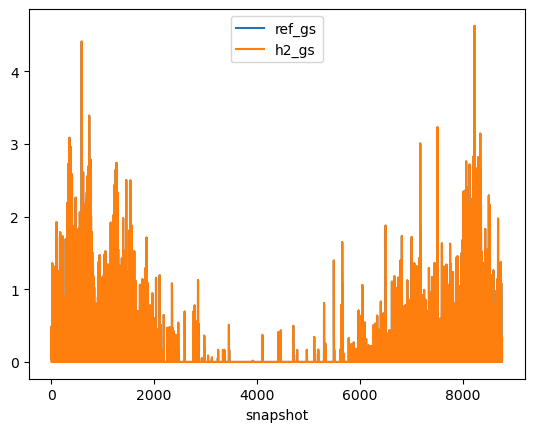

In [97]:
ref_gs = n_ref.generators_t.p.grid.sum()
h2_gs = n_h2.generators_t.p.grid.sum()
el_load = df_data['electric_load'].sum()

print("ref network grid supply: ", ref_gs)
print("h2 network grid supply: ", h2_gs)

res = pd.DataFrame()
res['ref_gs'] = n_ref.generators_t.p.grid
res['h2_gs'] = n_h2.generators_t.p.grid

res.plot()

In [98]:
n_ref.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
charge_bat,electricity,bat_bus,,AC,0.98,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,3.450845
discharge_bat,bat_bus,electricity,,AC,0.98,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,3.314192
housegrid_in,house_IO,electricity,,AC,1.00,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,10.644745
housegrid_out,electricity,house_IO,,AC,1.00,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.000000
wp,electricity,heat,,AC,1.00,0,inf,2.5,False,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,2.500000
charge_heat,heat,heat_storage_bus,,AC,0.95,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,9.140000
discharge_heat,heat_storage_bus,heat,,AC,0.95,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,5.989474


In [99]:
n_h2.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,bus2,efficiency2
Link,,,,,,,,,,,,,,,,,,,,,
charge_bat,electricity,bat_bus,,AC,0.980,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,3.450845,,0.0
discharge_bat,bat_bus,electricity,,AC,0.980,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,3.314192,,0.0
housegrid_in,house_IO,electricity,,AC,1.000,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,10.644745,,0.0
housegrid_out,electricity,house_IO,,AC,1.000,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.000000,,0.0
wp,electricity,heat,,AC,1.000,0,inf,2.5,False,0.0,...,0,1,0,NaN,NaN,1.0,1.0,2.500000,,0.0
charge_heat,heat,heat_storage_bus,,AC,0.950,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,9.140000,,0.0
discharge_heat,heat_storage_bus,heat,,AC,0.950,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,5.989474,,0.0
ely,electricity,h2_bus,,AC,0.625,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.000000,heat,0.2
fc,h2_bus,electricity,,AC,0.800,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.000000,heat,0.2


In [100]:
results_ref = auswertungsfunktion(n_ref, sensitivity_variable=0)
results_h2 = auswertungsfunktion(n_h2, sensitivity_variable=0)

results_ref

,Kapital- und marginale kosten €/a,Verbrauchseinsparung €/a,Marginale Kosten €/a,Ursprüngliche Energiekosten €/a,Investitionskosten €/a,Einspeiseverguetung €/a,Amortisationsdauer a,Netzbezug kWh/a,Netzeinspeisung kWh/a,PV-Ertragssumme kWh/a,Einspeicherung kWh/a,Auspeicherung kWh/a,Pufferspeicherkapazität kWh,Batteriepeicherkapazität kWh,Leistung Wärmepumpe kW
0,114532.606079,19005.016194,-16103.347653,2901.668541,130635.953733,-83327.43518,137.475235,1405.348457,208318.587949,214496.4,1228.578504,1126.954845,22.990675,3.381828,2.5


In [101]:
results_h2

,Kapital- und marginale kosten €/a,Verbrauchseinsparung €/a,Marginale Kosten €/a,Ursprüngliche Energiekosten €/a,Investitionskosten €/a,Einspeiseverguetung €/a,Amortisationsdauer a,Netzbezug kWh/a,Netzeinspeisung kWh/a,PV-Ertragssumme kWh/a,Einspeicherung kWh/a,Auspeicherung kWh/a,Pufferspeicherkapazität kWh,Batteriepeicherkapazität kWh,Leistung Wärmepumpe kW
0,114532.606079,19005.016194,-16103.347653,2901.668541,130635.953733,-83327.43518,137.475235,1405.348457,208318.587949,214496.4,1228.578504,1126.954845,22.990675,3.381828,2.5


In [102]:
n_ref.stores

attribute,bus,type,carrier,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,...,p_set,q_set,sign,marginal_cost,marginal_cost_quadratic,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
battery,bat_bus,,AC,0.0,True,0.0,inf,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,71.360,0.02,0,inf,3.381828
heat_storage,heat_storage_bus,,AC,0.0,True,0.0,36.85,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.666,0.08,0,inf,22.990675


In [103]:
n_h2.stores

attribute,bus,type,carrier,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,...,p_set,q_set,sign,marginal_cost,marginal_cost_quadratic,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
battery,bat_bus,,AC,0.0,True,0.0,inf,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,71.360,0.020,0,inf,3.381828
heat_storage,heat_storage_bus,,AC,0.0,True,0.0,36.85,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.666,0.080,0,inf,22.990675
h2_storage,h2_bus,,AC,0.0,True,0.0,inf,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1000.000,0.001,0,inf,0.000000


In [104]:
n_ref.stores_t.e.sum()

Store
battery          3852.604452
heat_storage    27176.789934
dtype: float64